In [47]:
from netCDF4 import Dataset
from glob import glob
import os, sys

is_py = os.path.basename(sys.argv[0]) == 'seabreeze-cross-sect.ju.py'
RUN_ID = int(sys.argv[1]) if is_py and len(sys.argv) > 1 else 9

root_dir = '/home/guc/'
data_dir = f'runs/{RUN_ID:03}*/'
root_data_dir = glob(root_dir + data_dir)[0]

image_dir = root_data_dir + 'results/images/'
if len(glob(image_dir)) == 0:
    os.mkdir(image_dir)

In [52]:
import matplotlib.pyplot as plt
import numpy as np

from wrf import getvar, to_np, extract_times, ALL_TIMES, vertcross, CoordPair

plt.rcParams["font.family"] = "DejaVu Sans Mono"

def plot_image(dataset: Dataset, var_name: str, debug: bool = False) -> None:
    times = extract_times(dataset, timeidx=ALL_TIMES)
    vert_levels = np.linspace(0, 2000, 200)
    if debug:
        times = times[20:25]
    for time_idx, datetime in enumerate(times):
        datetime_string = np.datetime_as_string(datetime, unit='m').replace('T', ' ')
        print(f"Saving {datetime_string}...", end='\r')

        var_data = getvar(dataset, var_name, time_idx)
        z_data = getvar(dataset, "z", time_idx)

        plot_lim = np.linspace(0, 5, 51)

        plt.figure(figsize=(10, 8)) # width, height
        ax = plt.axes()

        # === EDIT COORDS HERE ===
        START = (30.5, 140) # Y, X
        END = (39, 140) # Y, X

        start_point = CoordPair(lat = START[0], lon = START[1])
        end_point = CoordPair(lat = END[0], lon = END[1])
        var_cross = vertcross(
            var_data,
            z_data,
            levels=vert_levels,
            wrfin=dataset,
            start_point=start_point,
            end_point=end_point,
            latlon=True,
            meta=True,
            stagger='v'
        )

        vert_vals = to_np(var_cross.coords["vertical"])
        coord_pairs = to_np(var_cross.coords['xy_loc'])
        coord_pairs_labels = [pair.latlon_str(fmt='{:.2f}, {:.2f}') for pair in to_np(coord_pairs)]

        plt.ylabel('Height (m)')
        plt.xlabel('Coordinates')
        plt.contourf(coord_pairs_labels, vert_vals, np.abs(to_np(var_cross)), plot_lim, cmap="Spectral_r")
        plt.xticks(coord_pairs_labels[::len(coord_pairs_labels) // 3])
        cbar = plt.colorbar(shrink=.9, ticks=plot_lim[::5])
        cbar.ax.set_ylabel('W (m/s)')
        plt.title(f"Vertical Wind Speed (m/s) Cross Section, Real Model,\n Urban Grassland (AHE=1000) at\n{datetime_string}")

        if not debug:
            output_name = root_data_dir + 'results/images/' + np.datetime_as_string(datetime, unit='s') + '.png'
            plt.savefig(output_name)
            plt.clf()
            plt.close()

<xarray.DataArray 'PBLH' (south_north: 99, west_east: 99)> Size: 39kB
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)
Coordinates:
    XLONG    (south_north, west_east) float32 39kB 134.7 134.8 ... 145.8 145.9
    XLAT     (south_north, west_east) float32 39kB 30.32 30.33 ... 39.43 39.42
    XTIME    float32 4B 0.0
    Time     datetime64[ns] 8B 2025-03-09
Dimensions without coordinates: south_north, west_east
Attributes:
    FieldType:    104
    MemoryOrder:  XY 
    description:  PBL HEIGHT
    units:        m
    stagger:      
    coordinates:  XLONG XLAT XTIME
    projection:   LambertConformal(stand_lon=140.0, moad_cen_lat=35.000007629...


IndexError: tuple index out of range

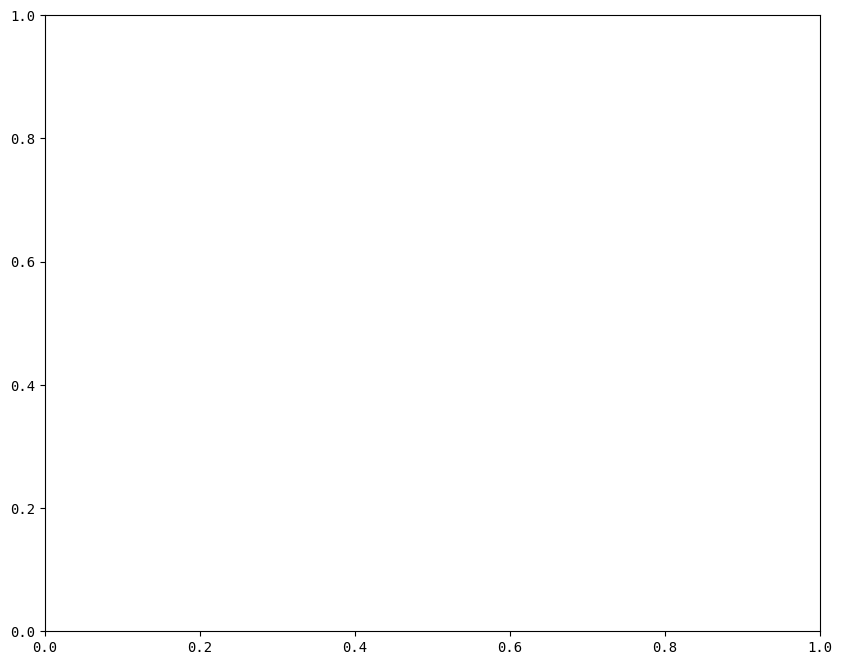

In [53]:
import subprocess
dataset = Dataset(glob(root_data_dir + 'wrfout*')[0])
plot_image(dataset, "wa", not is_py)

# Call ffmpeg to create video
if is_py:
    subprocess.call(['/home/guc/scripts/visualize/generate-video.sh', f'{RUN_ID:03}'])
    subprocess.call(['mv', 'out.mp4', root_dir + f'results/{RUN_ID:03}-{len(glob(root_dir + f'results/{RUN_ID:03}*.mp4')) + 1}.mp4'])
    for image_name in glob(image_dir + '*.png'):
        os.remove(image_name)
    print('Done!!')